In [ ]:
"""
This is random dataset from a Kaggle competition called the "Spaceship Titanic Dataset"

Link to kaggle competition -> https://www.kaggle.com/competitions/spaceship-titanic/overview

Most submissions had an accuracy < 83% except for 2 outliers.

In this notebook, i test a wide variety of model architectures using sklearn

note: this notebook was written in Kaggle thus you must change the directories and import the dataset before running it.
"""

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
training = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
test_original = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [ ]:
numeric_features = training[test.select_dtypes(include=["number"]).columns]
categorical_features = training[test.select_dtypes(exclude=["number"]).columns].drop(['PassengerId', 'Name'], axis=1)
label = training["Transported"]


cabin_split = categorical_features['Cabin'].str.split('/', expand=True)
categorical_features['Deck'] = cabin_split[0]
categorical_features['Cabin_num'] = cabin_split[1]
categorical_features['Side'] = cabin_split[2]

categorical_features.drop('Cabin',axis=1, inplace=True)

dummies = pd.get_dummies(categorical_features[['HomePlanet', 'Destination', 'Deck', 'Side']])
categorical_features.drop(['HomePlanet', 'Destination', 'Deck', 'Side'], axis=1, inplace=True)
categorical_features = pd.concat([categorical_features, dummies], axis=1)
features = pd.concat([numeric_features, categorical_features], axis=1)


#filling nulls
for i in ['Age', 'FoodCourt', 'ShoppingMall','RoomService', 'Spa', 'VRDeck']:
    features[i].fillna(features[i].median(), inplace=True)

for j in ['CryoSleep', 'VIP', 'Cabin_num']:
    features[j] = features[j].replace({"False": False, "True": True})
    features[j] = features[j].astype(bool)
    features[j].fillna(features[j].mode(), inplace=True)

features["Total"] = features[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for col in spending_cols:
    features['% of ' + str(col)] = (features[col] / (features['Total']+ 1e-7))


#log transform
to_log = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Total"]
for f in to_log:
    features["log_"+f] = np.log1p(features[f])


features_copy= features.copy()
label_copy = label.copy()

X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=42)
print(features.head())

In [ ]:
#normalize
num_columns = X_train.select_dtypes(include=['number']).columns
num_columns = [col for col in num_columns if not col.startswith("% of")]

from sklearn.preprocessing import StandardScaler
print(len(X_train.columns), len(X_test.columns))
scaler = StandardScaler().fit(X_train[num_columns])


X_train[num_columns] = scaler.transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

X_train.head()

In [ ]:
models = {}

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, C=3).fit(X_train, y_train)
models["lr"] = lr


from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier().fit(X_train, y_train)
models['rr'] = rr


from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
models['dt'] = dt


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=401, max_depth=7, min_samples_split=2).fit(X_train, y_train)
models['rf'] = rf


from xgboost import XGBClassifier

xgb = XGBClassifier(alpha=10).fit(X_train, y_train)
models['xgb'] = xgb


from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=0.08254041852680192,
                    hidden_layer_sizes=(200, 100),
                    max_iter=2000,
                    early_stopping=False,
                    learning_rate='adaptive',
                    learning_rate_init=0.0001,
                    activation='tanh').fit(X_train, y_train)
models['mlp'] = mlp

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train)
models['gb'] = gb

In [ ]:
mlp2 = MLPClassifier(alpha=0.01,
                    hidden_layer_sizes=(60, 60, 35, 35, 20, 15),
                    max_iter=10000,
                    early_stopping=True,
                    learning_rate='adaptive',
                    learning_rate_init=0.0024,
                    activation='relu').fit(X_train, y_train)

mlp2.score(X_train, y_train), mlp2.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(mlp2.loss_curve_)
plt.title("MLP Loss Curve During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
#scores

for model in list(models.keys()):
    print("Test Score: " + model + " score: " + str(models[model].score(X_test, y_test)))
    print("Training Score: " + model + " score: " + str(models[model].score(X_train, y_train)) + "\n")

In [ ]:
#tuning
from sklearn.model_selection import RandomizedSearchCV

grid_pararms_rf = {'max_depth':np.arange(1, 10),
                  'n_estimators': np.arange(50, 401, 50),
                  'min_samples_split': np.arange(2, 10),
                  'warm_start': [True, False]}
rs_rf = RandomizedSearchCV(estimator=rf,param_distributions=grid_pararms_rf, scoring='accuracy', n_jobs=-1,n_iter=100).fit(X_train,y_train)


In [ ]:
print(rs_rf.best_score_, rs_rf.best_params_)
print("\n")

l = []
for i  in zip(features.columns,rf.feature_importances_):
    l.append(i)
print(sorted(l, key=lambda x: x[1], reverse=True))

In [ ]:
params_mlp = {'alpha':np.logspace(-4,1, 25),
            'learning_rate_init': np.logspace(-4, 0, 10),
            'hidden_layer_sizes': [(50,), (100,), (200,),
                                   (50, 50), (100, 50), (200, 100),
                                   (100, 50, 25), (200, 100, 50),
                                  (50, 75, 100, 125),(50,75,100,125,150)],
            'max_iter': np.arange(1000, 4000, 1000),
            'early_stopping':[True, False],
            'activation': ['relu', 'tanh', 'logistic'],
            'learning_rate': ['constant', 'invscaling', 'adaptive']}

rs_mlp = RandomizedSearchCV(estimator=mlp,param_distributions=params_mlp, scoring='accuracy', n_jobs=-1, n_iter=100).fit(X_train,y_train)

In [ ]:
rs_mlp.best_score_, rs_mlp.best_params_

In [ ]:
#XGBoost

params_xgb = {'n_estimators': np.arange(2, 403, 20),
             'max_depth': np.arange(2, 13, 1),
             'learning_rate': np.logspace(-4,1),
             }
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb, scoring='accuracy', n_jobs=-1, n_iter=100).fit(X_train, y_train)

In [ ]:
rs_xgb.best_score_, rs_xgb.best_params_

#Best scores so far:

RF:

0.8048790191582427 {'warm_start': True, 'n_estimators': 250, 'min_samples_split': 5, 'max_depth': 9}


MLP:

(0.8081001134710366, {'max_iter': 2000, 'learning_rate_init': 0.000774263682681127, 'learning_rate': 'constant', 'hidden_layer_sizes': (200, 100), 'early_stopping': True, 'alpha': 0.004641588833612782, 'activation': 'relu'})


XGB: (0.8050319225571945, {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.07196856730011521})

On the test dataset, the mlp model achieved a score of 0.80243
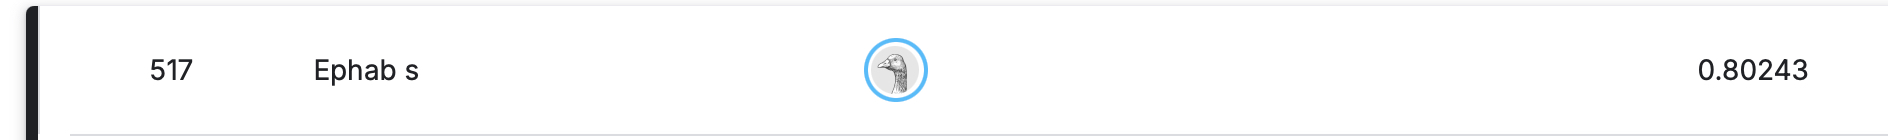